In [1]:

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.windows import Window
from rasterio.enums import Resampling
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    # File paths
    'dem_path': 'data/processed/dem_honolulu.tif',
    'waterways_path': 'data/processed/waterways_honolulu.shp',
    'coastline_path': 'data/processed/lines_honolulu.shp',  # NOT used for proximity
    'boundary_path': 'data/processed/honolulu_boundary.shp',
    'census_path': 'data/processed/census_bg_honolulu.shp',
    'output_dir': 'data/processed',
    'figures_dir': 'outputs/figures',
    
    # Processing parameters
    'target_resolution': 10,  # meters - higher res than before
    'chunk_size': 2048,       # pixels per chunk (tuned for 16GB RAM)
    
    # Model parameters
    'elevation_weight': 0.70,  # 70% weight to elevation
    'proximity_weight': 0.30,  # 30% weight to proximity
    
    # Elevation thresholds (meters)
    'elev_high_risk': 3,      # < 3m = high risk
    'elev_mod_risk': 8,       # 3-8m = moderate risk
                              # > 8m = low risk
    
    # Proximity thresholds (meters from inland waterways)
    'prox_high_risk': 100,    # < 100m = high risk  
    'prox_mod_risk': 500,     # 100-500m = moderate risk
                              # > 500m = low risk
}

# Create output directories
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)
Path(CONFIG['figures_dir']).mkdir(parents=True, exist_ok=True)

print("✓ Configuration loaded")
print(f"  Target resolution: {CONFIG['target_resolution']}m")
print(f"  Weighting: {CONFIG['elevation_weight']*100:.0f}% elevation, {CONFIG['proximity_weight']*100:.0f}% proximity")

✓ Configuration loaded
  Target resolution: 10m
  Weighting: 70% elevation, 30% proximity


In [2]:

print("Loading vector data...")

# Load boundary
honolulu = gpd.read_file(CONFIG['boundary_path'])
print(f"✓ Honolulu boundary loaded")

# Load INLAND WATERWAYS ONLY (streams, rivers - NOT coastline)
waterways = gpd.read_file(CONFIG['waterways_path'])
print(f"✓ Inland waterways loaded: {len(waterways)} features")
print(f"  Total stream length: {waterways.length.sum()/1000:.1f} km")

# Load coastline (for reference/visualization only, NOT for proximity)
coastline = gpd.read_file(CONFIG['coastline_path'])
print(f"✓ Coastline loaded: {len(coastline)} features (NOT used for proximity)")

# Load census block groups
census_bg = gpd.read_file(CONFIG['census_path'])
print(f"✓ Census block groups loaded: {len(census_bg)} features")

# Get DEM metadata for reference
with rasterio.open(CONFIG['dem_path']) as src:
    dem_crs = src.crs
    dem_bounds = src.bounds
    dem_res = src.res[0]
    dem_shape = src.shape
    dem_transform = src.transform
    dem_meta = src.meta.copy()
    
print(f"\n✓ DEM metadata loaded:")
print(f"  Shape: {dem_shape[0]} × {dem_shape[1]} pixels")
print(f"  Resolution: {dem_res:.2f}m")
print(f"  CRS: {dem_crs}")

Loading vector data...
✓ Honolulu boundary loaded
✓ Inland waterways loaded: 2340 features
  Total stream length: 7849.1 km
✓ Coastline loaded: 4 features (NOT used for proximity)
✓ Census block groups loaded: 774 features

✓ DEM metadata loaded:
  Shape: 52758 × 67740 pixels
  Resolution: 3.28m
  CRS: EPSG:3759


In [3]:

print(f"Creating {CONFIG['target_resolution']}m resolution working raster...")

# Calculate new dimensions for target resolution
scale_factor = dem_res / CONFIG['target_resolution']

if scale_factor < 1:
    new_height = int(dem_shape[0] * scale_factor)
    new_width = int(dem_shape[1] * scale_factor)
    print(f"  Upsampling from {dem_res:.1f}m to {CONFIG['target_resolution']}m")
else:
    new_height = int(dem_shape[0] / scale_factor)
    new_width = int(dem_shape[1] / scale_factor)
    print(f"  Downsampling from {dem_res:.1f}m to {CONFIG['target_resolution']}m")

# Read DEM at target resolution
with rasterio.open(CONFIG['dem_path']) as src:
    dem = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.bilinear
    )
    
    # Calculate new transform
    new_transform = src.transform * src.transform.scale(
        src.width / new_width,
        src.height / new_height
    )

# Handle nodata
nodata_val = dem_meta.get('nodata', -9999)
dem = np.where(dem == nodata_val, np.nan, dem)
dem = np.where(dem < -100, np.nan, dem)

# Calculate memory usage
mem_mb = dem.nbytes / (1024 * 1024)
print(f"\n✓ DEM loaded at working resolution")
print(f"  Shape: {dem.shape[0]} × {dem.shape[1]} pixels")
print(f"  Actual resolution: {new_transform[0]:.2f}m")
print(f"  Memory usage: {mem_mb:.1f} MB")
print(f"  Valid pixels: {np.sum(~np.isnan(dem)):,} ({np.sum(~np.isnan(dem))/dem.size*100:.1f}%)")
print(f"  Elevation range: {np.nanmin(dem):.1f}m to {np.nanmax(dem):.1f}m")

# Store working metadata
working_meta = dem_meta.copy()
working_meta.update({
    'height': new_height,
    'width': new_width,
    'transform': new_transform,
    'dtype': 'float32'
})

Creating 10m resolution working raster...
  Upsampling from 3.3m to 10m

✓ DEM loaded at working resolution
  Shape: 17313 × 22229 pixels
  Actual resolution: 10.00m
  Memory usage: 1468.1 MB
  Valid pixels: 148,162,755 (38.5%)
  Elevation range: -83.1m to 1216.8m


In [4]:

print("Classifying elevation-based flood risk...")

def classify_elevation_risk(elev_array, high_thresh, mod_thresh):
    """
    Classify elevation into flood risk categories.
    LOW elevation = HIGH flood risk
    HIGH elevation = LOW flood risk
    """
    risk = np.zeros_like(elev_array, dtype=np.uint8)
    
    # High risk: below high threshold (closest to sea level)
    risk[elev_array < high_thresh] = 3
    
    # Moderate risk: between thresholds
    risk[(elev_array >= high_thresh) & (elev_array < mod_thresh)] = 2
    
    # Low risk: above moderate threshold
    risk[elev_array >= mod_thresh] = 1
    
    # No data
    risk[np.isnan(elev_array)] = 0
    
    return risk

elevation_risk = classify_elevation_risk(
    dem, 
    CONFIG['elev_high_risk'], 
    CONFIG['elev_mod_risk']
)

# Statistics
valid_pixels = np.sum(elevation_risk > 0)
high_pct = np.sum(elevation_risk == 3) / valid_pixels * 100
mod_pct = np.sum(elevation_risk == 2) / valid_pixels * 100
low_pct = np.sum(elevation_risk == 1) / valid_pixels * 100

print(f"\n✓ Elevation risk classification complete")
print(f"  Thresholds: High risk < {CONFIG['elev_high_risk']}m, Moderate < {CONFIG['elev_mod_risk']}m")
print(f"\n  Distribution:")
print(f"    High risk (coastal):    {np.sum(elevation_risk == 3):>10,} pixels ({high_pct:>5.1f}%)")
print(f"    Moderate risk:          {np.sum(elevation_risk == 2):>10,} pixels ({mod_pct:>5.1f}%)")
print(f"    Low risk (elevated):    {np.sum(elevation_risk == 1):>10,} pixels ({low_pct:>5.1f}%)")
print(f"    No data:                {np.sum(elevation_risk == 0):>10,} pixels")

Classifying elevation-based flood risk...

✓ Elevation risk classification complete
  Thresholds: High risk < 3m, Moderate < 8m

  Distribution:
    High risk (coastal):    42,115,314 pixels ( 28.4%)
    Moderate risk:          10,918,984 pixels (  7.4%)
    Low risk (elevated):    95,128,457 pixels ( 64.2%)
    No data:                236,687,922 pixels


In [5]:

print("Calculating proximity to inland waterways...")
print("  NOTE: Using ONLY streams/rivers, NOT coastline")

# Rasterize waterways to binary mask
waterway_shapes = [(geom, 1) for geom in waterways.geometry]

waterway_mask = rasterize(
    waterway_shapes,
    out_shape=(new_height, new_width),
    transform=new_transform,
    fill=0,
    dtype=np.uint8,
    all_touched=True
)

print(f"  Waterway pixels: {np.sum(waterway_mask > 0):,}")

# Calculate Euclidean distance transform
distance_pixels = distance_transform_edt(waterway_mask == 0)
distance_meters = distance_pixels * CONFIG['target_resolution']

print(f"  Distance range: {distance_meters.min():.0f}m to {distance_meters.max():.0f}m")
print(f"  Mean distance: {np.nanmean(distance_meters):.0f}m")

# Classify into risk categories
def classify_proximity_risk(dist_array, high_thresh, mod_thresh):
    """
    Classify proximity to waterways into flood risk categories.
    CLOSE to waterways = HIGH risk
    FAR from waterways = LOW risk
    """
    risk = np.ones_like(dist_array, dtype=np.uint8)  # Default to low risk
    
    # High risk: very close to waterways
    risk[dist_array < high_thresh] = 3
    
    # Moderate risk: intermediate distance
    risk[(dist_array >= high_thresh) & (dist_array < mod_thresh)] = 2
    
    return risk

proximity_risk = classify_proximity_risk(
    distance_meters,
    CONFIG['prox_high_risk'],
    CONFIG['prox_mod_risk']
)

# Apply nodata mask from DEM
proximity_risk[np.isnan(dem)] = 0

# Statistics
valid_pixels = np.sum(proximity_risk > 0)
high_pct = np.sum(proximity_risk == 3) / valid_pixels * 100
mod_pct = np.sum(proximity_risk == 2) / valid_pixels * 100
low_pct = np.sum(proximity_risk == 1) / valid_pixels * 100

print(f"\n✓ Proximity risk classification complete")
print(f"  Thresholds: High risk < {CONFIG['prox_high_risk']}m, Moderate < {CONFIG['prox_mod_risk']}m")
print(f"\n  Distribution:")
print(f"    High risk (near water): {np.sum(proximity_risk == 3):>10,} pixels ({high_pct:>5.1f}%)")
print(f"    Moderate risk:          {np.sum(proximity_risk == 2):>10,} pixels ({mod_pct:>5.1f}%)")
print(f"    Low risk (far):         {np.sum(proximity_risk == 1):>10,} pixels ({low_pct:>5.1f}%)")

Calculating proximity to inland waterways...
  NOTE: Using ONLY streams/rivers, NOT coastline
  Waterway pixels: 992,894
  Distance range: 0m to 95129m
  Mean distance: 14533m

✓ Proximity risk classification complete
  Thresholds: High risk < 100m, Moderate < 500m

  Distribution:
    High risk (near water):  8,640,313 pixels (  5.8%)
    Moderate risk:          29,929,507 pixels ( 20.2%)
    Low risk (far):         109,592,935 pixels ( 74.0%)


In [6]:

print("Creating composite flood risk score...")
print(f"  Weights: {CONFIG['elevation_weight']*100:.0f}% elevation, {CONFIG['proximity_weight']*100:.0f}% proximity")

# Create weighted composite (continuous score)
composite_continuous = (
    CONFIG['elevation_weight'] * elevation_risk.astype(float) +
    CONFIG['proximity_weight'] * proximity_risk.astype(float)
)

# Handle nodata
composite_continuous[elevation_risk == 0] = np.nan

print(f"  Composite score range: {np.nanmin(composite_continuous):.2f} to {np.nanmax(composite_continuous):.2f}")

# Classify composite into final risk categories
def classify_composite_risk(composite_array):
    """
    Classify weighted composite score into final risk categories.
    """
    risk = np.zeros_like(composite_array, dtype=np.uint8)
    
    # Low risk
    risk[composite_array < 1.5] = 1
    
    # Moderate risk
    risk[(composite_array >= 1.5) & (composite_array < 2.3)] = 2
    
    # High risk
    risk[composite_array >= 2.3] = 3
    
    # No data
    risk[np.isnan(composite_array)] = 0
    
    return risk

final_flood_risk = classify_composite_risk(composite_continuous)

# Statistics
valid_pixels = np.sum(final_flood_risk > 0)
pixel_area_m2 = CONFIG['target_resolution'] ** 2
pixel_area_km2 = pixel_area_m2 / 1e6

print(f"\n✓ Final flood risk classification complete")
print(f"\n  Distribution:")
for risk_level, label in [(3, 'High'), (2, 'Moderate'), (1, 'Low')]:
    count = np.sum(final_flood_risk == risk_level)
    pct = count / valid_pixels * 100
    area = count * pixel_area_km2
    print(f"    {label:12} risk: {count:>10,} pixels ({pct:>5.1f}%) = {area:>6.1f} km²")

total_area = valid_pixels * pixel_area_km2
print(f"\n  Total analyzed area: {total_area:.1f} km²")

Creating composite flood risk score...
  Weights: 70% elevation, 30% proximity
  Composite score range: 1.00 to 3.00

✓ Final flood risk classification complete

  Distribution:
    High         risk: 42,627,644 pixels ( 28.8%) = 4262.8 km²
    Moderate     risk: 18,035,316 pixels ( 12.2%) = 1803.5 km²
    Low          risk: 87,499,795 pixels ( 59.1%) = 8750.0 km²

  Total analyzed area: 14816.3 km²


Creating visualization...


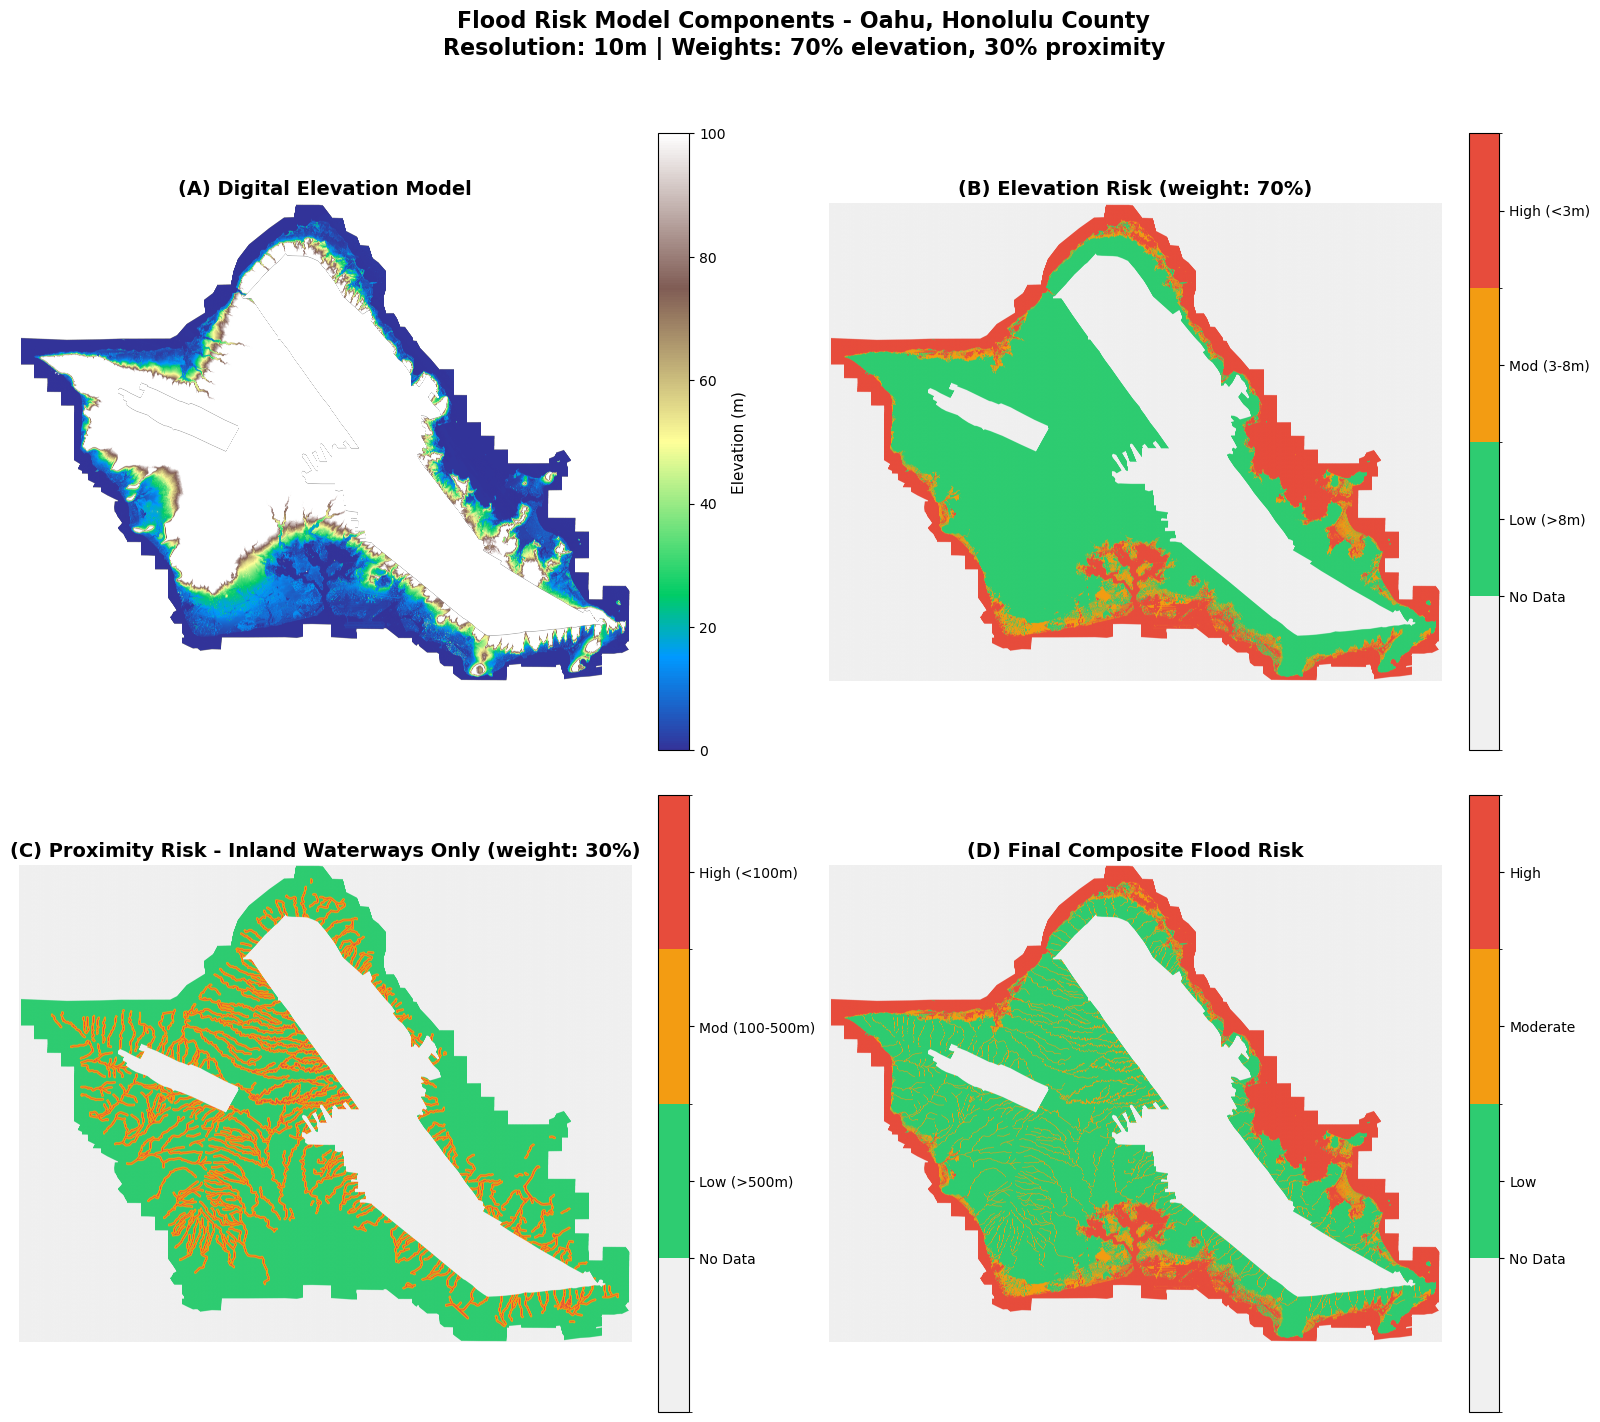

✓ Saved: outputs/figures/flood_risk_components.png


In [7]:

print("Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Color maps
risk_colors = ['#f0f0f0', '#2ecc71', '#f39c12', '#e74c3c']
risk_cmap = ListedColormap(risk_colors)
risk_norm = BoundaryNorm([0, 0.5, 1.5, 2.5, 3.5], risk_cmap.N)

# Panel A: Elevation
im1 = axes[0, 0].imshow(dem, cmap='terrain', vmin=0, vmax=100)
axes[0, 0].set_title('(A) Digital Elevation Model', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
cbar1.set_label('Elevation (m)', fontsize=11)

# Panel B: Elevation Risk
im2 = axes[0, 1].imshow(elevation_risk, cmap=risk_cmap, norm=risk_norm)
axes[0, 1].set_title(f'(B) Elevation Risk (weight: {CONFIG["elevation_weight"]*100:.0f}%)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04, ticks=[0.5, 1, 2, 3])
cbar2.ax.set_yticklabels(['No Data', f'Low (>{CONFIG["elev_mod_risk"]}m)', 
                          f'Mod ({CONFIG["elev_high_risk"]}-{CONFIG["elev_mod_risk"]}m)', 
                          f'High (<{CONFIG["elev_high_risk"]}m)'])

# Panel C: Proximity Risk
im3 = axes[1, 0].imshow(proximity_risk, cmap=risk_cmap, norm=risk_norm)
axes[1, 0].set_title(f'(C) Proximity Risk - Inland Waterways Only (weight: {CONFIG["proximity_weight"]*100:.0f}%)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].axis('off')
cbar3 = plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04, ticks=[0.5, 1, 2, 3])
cbar3.ax.set_yticklabels(['No Data', f'Low (>{CONFIG["prox_mod_risk"]}m)', 
                          f'Mod ({CONFIG["prox_high_risk"]}-{CONFIG["prox_mod_risk"]}m)', 
                          f'High (<{CONFIG["prox_high_risk"]}m)'])

# Panel D: Final Composite Risk
im4 = axes[1, 1].imshow(final_flood_risk, cmap=risk_cmap, norm=risk_norm)
axes[1, 1].set_title('(D) Final Composite Flood Risk', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')
cbar4 = plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04, ticks=[0.5, 1, 2, 3])
cbar4.ax.set_yticklabels(['No Data', 'Low', 'Moderate', 'High'])

plt.suptitle('Flood Risk Model Components - Oahu, Honolulu County\n' +
             f'Resolution: {CONFIG["target_resolution"]}m | ' +
             f'Weights: {CONFIG["elevation_weight"]*100:.0f}% elevation, {CONFIG["proximity_weight"]*100:.0f}% proximity',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(f'{CONFIG["figures_dir"]}/flood_risk_components.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {CONFIG['figures_dir']}/flood_risk_components.png")

Creating waterway distance visualization...


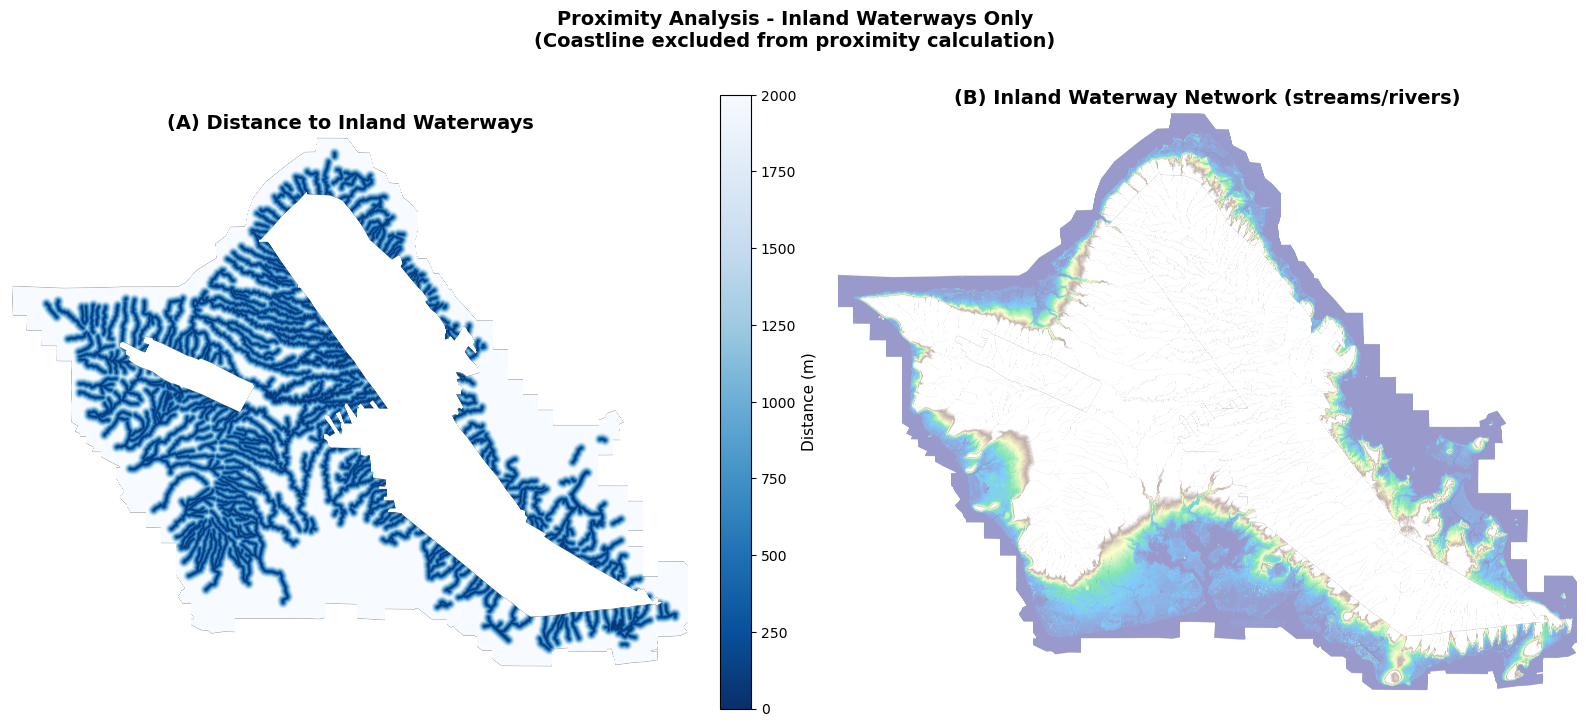

✓ Saved: outputs/figures/waterway_distance.png


In [8]:

print("Creating waterway distance visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Panel A: Distance to waterways (continuous)
dist_display = np.clip(distance_meters, 0, 2000)
dist_display[np.isnan(dem)] = np.nan

im1 = axes[0].imshow(dist_display, cmap='Blues_r', vmin=0, vmax=2000)
axes[0].set_title('(A) Distance to Inland Waterways', fontsize=14, fontweight='bold')
axes[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Distance (m)', fontsize=11)

# Panel B: Waterway network overlay
axes[1].imshow(dem, cmap='terrain', alpha=0.5, vmin=0, vmax=100)
waterway_display = np.ma.masked_where(waterway_mask == 0, waterway_mask)
axes[1].imshow(waterway_display, cmap='Blues', alpha=0.8)
axes[1].set_title('(B) Inland Waterway Network (streams/rivers)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Proximity Analysis - Inland Waterways Only\n(Coastline excluded from proximity calculation)',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(f'{CONFIG["figures_dir"]}/waterway_distance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {CONFIG['figures_dir']}/waterway_distance.png")

In [9]:

print("Saving risk rasters...")

# Update metadata for output
output_meta = working_meta.copy()
output_meta.update({
    'dtype': 'uint8',
    'nodata': 0
})

# Save elevation risk
output_path = f'{CONFIG["output_dir"]}/elevation_risk.tif'
with rasterio.open(output_path, 'w', **output_meta) as dst:
    dst.write(elevation_risk, 1)
print(f"✓ Saved: {output_path}")

# Save proximity risk
output_path = f'{CONFIG["output_dir"]}/proximity_risk.tif'
with rasterio.open(output_path, 'w', **output_meta) as dst:
    dst.write(proximity_risk, 1)
print(f"✓ Saved: {output_path}")

# Save distance to waterways (continuous)
dist_meta = working_meta.copy()
dist_meta.update({
    'dtype': 'float32',
    'nodata': -9999
})
output_path = f'{CONFIG["output_dir"]}/waterway_distance.tif'
dist_output = np.where(np.isnan(dem), -9999, distance_meters)
with rasterio.open(output_path, 'w', **dist_meta) as dst:
    dst.write(dist_output.astype('float32'), 1)
print(f"✓ Saved: {output_path}")

# Save composite score (continuous)
output_path = f'{CONFIG["output_dir"]}/composite_risk_continuous.tif'
composite_output = np.where(np.isnan(composite_continuous), -9999, composite_continuous)
with rasterio.open(output_path, 'w', **dist_meta) as dst:
    dst.write(composite_output.astype('float32'), 1)
print(f"✓ Saved: {output_path}")

# Save final flood risk (categorical)
output_path = f'{CONFIG["output_dir"]}/final_flood_risk.tif'
with rasterio.open(output_path, 'w', **output_meta) as dst:
    dst.write(final_flood_risk, 1)
print(f"✓ Saved: {output_path}")

print("\n✓ All risk rasters saved to data/processed/")

Saving risk rasters...
✓ Saved: data/processed/elevation_risk.tif
✓ Saved: data/processed/proximity_risk.tif
✓ Saved: data/processed/waterway_distance.tif
✓ Saved: data/processed/composite_risk_continuous.tif
✓ Saved: data/processed/final_flood_risk.tif

✓ All risk rasters saved to data/processed/


In [10]:

print("=" * 70)
print("FLOOD RISK MODELING SUMMARY")
print("=" * 70)

print(f"\n Model Configuration:")
print(f"   Resolution: {CONFIG['target_resolution']}m")
print(f"   Elevation weight: {CONFIG['elevation_weight']*100:.0f}%")
print(f"   Proximity weight: {CONFIG['proximity_weight']*100:.0f}%")

print(f"\n Elevation Thresholds:")
print(f"   High risk: < {CONFIG['elev_high_risk']}m")
print(f"   Moderate risk: {CONFIG['elev_high_risk']}-{CONFIG['elev_mod_risk']}m")
print(f"   Low risk: > {CONFIG['elev_mod_risk']}m")

print(f"\n Proximity Thresholds (inland waterways only):")
print(f"   High risk: < {CONFIG['prox_high_risk']}m from stream/river")
print(f"   Moderate risk: {CONFIG['prox_high_risk']}-{CONFIG['prox_mod_risk']}m")
print(f"   Low risk: > {CONFIG['prox_mod_risk']}m")

print(f"\n Final Risk Distribution:")
valid_pixels = np.sum(final_flood_risk > 0)
for risk_level, label, color in [(3, 'High', '🔴'), (2, 'Moderate', '🟠'), (1, 'Low', '🟢')]:
    count = np.sum(final_flood_risk == risk_level)
    pct = count / valid_pixels * 100
    area = count * pixel_area_km2
    print(f"   {color} {label:12}: {pct:>5.1f}% ({area:>6.1f} km²)")

print(f"\n   Total analyzed area: {valid_pixels * pixel_area_km2:.1f} km²")

print(f"\n Output Files:")
print(f"   - elevation_risk.tif")
print(f"   - proximity_risk.tif") 
print(f"   - waterway_distance.tif")
print(f"   - composite_risk_continuous.tif")
print(f"   - final_flood_risk.tif")

print("\n" + "=" * 70)
print("✓ Flood risk modeling complete!")
print("  → Proceed to notebook 03 for population exposure analysis")
print("=" * 70)

FLOOD RISK MODELING SUMMARY

📊 Model Configuration:
   Resolution: 10m
   Elevation weight: 70%
   Proximity weight: 30%

⛰️ Elevation Thresholds:
   High risk: < 3m
   Moderate risk: 3-8m
   Low risk: > 8m

🌊 Proximity Thresholds (inland waterways only):
   High risk: < 100m from stream/river
   Moderate risk: 100-500m
   Low risk: > 500m

📈 Final Risk Distribution:
   🔴 High        :  28.8% (4262.8 km²)
   🟠 Moderate    :  12.2% (1803.5 km²)
   🟢 Low         :  59.1% (8750.0 km²)

   Total analyzed area: 14816.3 km²

📁 Output Files:
   - elevation_risk.tif
   - proximity_risk.tif
   - waterway_distance.tif
   - composite_risk_continuous.tif
   - final_flood_risk.tif

✓ Flood risk modeling complete!
  → Proceed to notebook 03 for population exposure analysis
